# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
SEED = 12345

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=SEED)

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
labels.shape

(7591, 2)

In [6]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


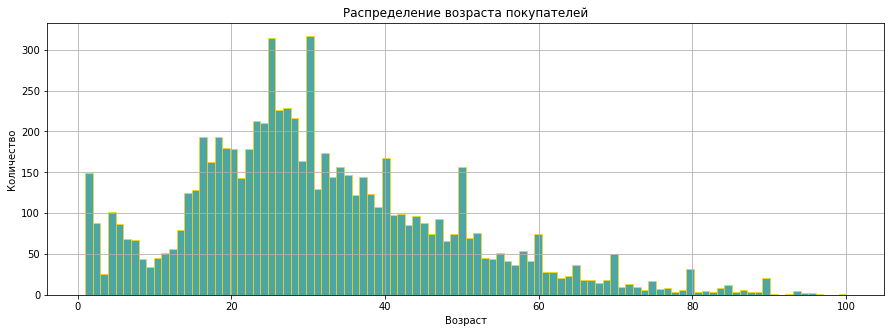

In [7]:
# Построим график распределения возраста в выборке
labels['real_age'].hist(figsize=(15, 5), bins=100, alpha=0.7, color='teal', edgecolor = 'gold')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возраста покупателей')
plt.show()

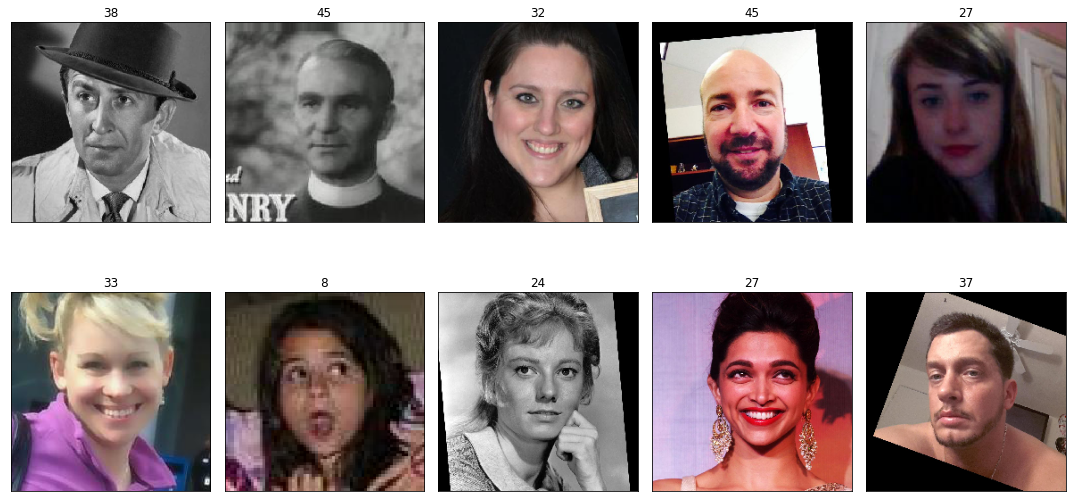

In [43]:
# Напечатаем на экране 10 фотографий и посмотрим, как устроен датасет
features, target = next(train_datagen_flow)
fig = plt.figure(figsize=(15,10))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.title(target[i]) 
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Провели исследовательский анализ данных:
- Посмотрели на размер выборки.
- Построили график распределения возраста в выборке. 
- Напечатали на экране 10 фотографий и посмотрели, как устроен датасет.

Вывод:
- В датасете 7591 фотография. Выборка относительно небольшая.
- Больше всего фотографий в диапазоне от 20 до 41 года. Пики в районе "юбилейных" лет, они тут могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он попросту округлял его. 
- В основном фото цветные, но есть и чёрно-белые.
- Выборка содержит обрезанные, повернутые и фото с низким разрешением.
- Общая ориентация фотографий вертикальная.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.0001)
SEED = 12345


def load_train(path):  
    labels = pd.read_csv(path + 'labels.csv') 
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       horizontal_flip=True,
                                       rescale=1./255) 
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels, 
        directory=path+'final_files/',  
        x_col="file_name",  
        y_col="real_age",  
        target_size=(224, 224), 
        batch_size=16, 
        class_mode='raw', 
        subset='training', 
        seed=SEED) 

    return train_datagen_flow 


def load_test(path):  
    labels = pd.read_csv(path + 'labels.csv') 
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1./255) 
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16, 
        class_mode='raw', 
        subset='validation',
        seed=SEED) 

    return test_datagen_flow 


def create_model(input_shape): 
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False) 

    model = Sequential() 
    model.add(backbone) 
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(units=1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])  

    return model  


def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=None, epochs=10, 
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_datagen_flow) 
    if validation_steps is None: 
        validation_steps = len(test_datagen_flow) 

    model.fit(train_datagen_flow,
              validation_data=test_datagen_flow, 
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, 
              batch_size=batch_size, 
              epochs=epochs, 
              verbose=2, shuffle=True)

    return model

```

```
Test MAE: 6.5497

```

## Анализ обученной модели

Построили модель, которая по фотографии определит приблизительный возраст человека.

Модель поможет определять возраст клиентов в прикассовой зоне сетевого супермаркета «Хлеб-Соль», чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

С помощью свёрточной нейронной сети ResNet50 глубиной в 50 слоев удалось получить значение метрики MAE = 6.5497 на тестовой выборке, что соответсвует требованию в условии задачи проекта.